In [443]:
# Imports
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import ipywidgets as ipw
import base64

In [444]:
# Use the RFSoC overlay
base = BaseOverlay('base.bit')
from pynq.overlays.base import BaseOverlay

# Start RF clocks
base.init_rf_clks()


# Channels
#print("Transmitter channels:\n",base.radio.transmitter.get_channel_description())
DAC_CHANNEL_B = 0 # 'Channel 0': {'Tile': 224, 'Block': 0}
DAC_CHANNEL_A = 1 # 'Channel 1': {'Tile': 230, 'Block': 0}

#print("Receiver channels:\n",base.radio.receiver.get_channel_description())
ADC_CHANNEL_D = 0 # 'Channel 0': {'Tile': 224, 'Block': 0}
ADC_CHANNEL_C = 1 # 'Channel 1': {'Tile': 224, 'Block': 1}
ADC_CHANNEL_B = 2 # 'Channel 2': {'Tile': 226, 'Block': 0}
ADC_CHANNEL_A = 3 # 'Channel 3': {'Tile': 226, 'Block': 1}

In [445]:
# Set the center frequency and sampling frequency
center_frequency = 1240e6  # Hz Frequency of incoming signal
sample_frequency = 2457.6e6  # Hz I believe the default sample frequency is 2457.6e6 Hz which is sufficient for our signal
downsample_factor = 2  # Choose how much to decimate by i.e '2' decimates 2x
number_samples = 512  # Between 16 and 32768

# Set mixer frequency to center frequency to demodulate carrier frequency
base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings['Freq'] = 1240 # MHz
base.radio.receiver.channel[ADC_CHANNEL_C].adc_block.MixerSettings['Freq'] = 1240 # MHz
base.radio.receiver.channel[ADC_CHANNEL_B].adc_block.MixerSettings['Freq'] = 1240 # MHz
base.radio.receiver.channel[ADC_CHANNEL_A].adc_block.MixerSettings['Freq'] = 1240 # MHz

base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings['MixerMode'] = 3 # 3 is default, 1 does something, nothing else valid
base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings['MixerType'] = 2 # 2 is default
base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings['PhaseOffset'] = 0.0 # Use if result is noisy or slightly off


In [446]:
# View configurable settings of ADCs
#help(base.radio.receiver.channel[0].adc_block.MixerSettings)
#help(base.radio.receiver.channel[0].adc_tile)

print(base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings)

{'Freq': 1239.999999999994, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 1, 'MixerType': 2}


In [447]:
# Function to plot real and imaginary data in time domain
def plot_complex_time(data, n, fs=sample_frequency, 
                      title='Complex Time Plot'):
    plt_re_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.real(data), name='Real'))
    plt_im_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.imag(data), name='Imag'))
    return go.FigureWidget(data = [plt_re_temp, plt_im_temp],
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Seconds (s)',
                                         'autorange' : True},
                                     'yaxis': {
                                         'title': 'Amplitude (V)'}})

def plot_time(data, n, fs=sample_frequency, 
                      title='Complex Time Plot'):
    plt_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = data))
    return go.FigureWidget(data = plt_temp,
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Seconds (s)',
                                         'autorange' : True},
                                     'yaxis': {
                                         'title': 'Amplitude (V)'}})

# Functions
# Function to convert integer to binary array
def int_to_binary_array(num, num_bits):
    return np.array(list(format(num, f'0{num_bits}b')), dtype=int)

# Function to convert binary array to integer
def binary_array_to_int(binary_array):
    return int(''.join(map(str, binary_array)), 2)

In [448]:
# Sample
raw_data = []  # Storage for incoming I and Q data
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    raw_data.append(base.radio.receiver.channel[i].transfer(number_samples))
#print(raw_data[ADC_CHANNEL_D])
#print("raw_data: ", raw_data[ADC_CHANNEL_D])
#print("number_samples: ", number_samples)

In [449]:
# Plotting raw data in the time domain
figs = [] # Storage for ADC time domain plots

# Add plots to figs
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    figs.append(plot_complex_time(
        data=raw_data[i], 
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel ', str(i), ' Before Downconversion'])))
    
# plot ADC real and imaginary time domain data
ipw.VBox(figs)

# THESE SHOULD LOOK LIKE THE MODULATED WAVES

    'data': [{'name': 'Real',
              'type': 'scatter',
              'ui…

In [450]:
# Animate time domain plot
import time

figs = [] # Storage for ADC time domain plots
number_animations = 20

# Add plots to figs
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, number_animations): # Show only ADC D
    #for i in range(0, len(base.radio.receiver.channel)): # Show all plots
    for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
        raw_data.append(base.radio.receiver.channel[i].transfer(number_samples))
        figs.append(plot_complex_time(
            data=raw_data[i], 
            n=number_samples,
            title=''.join(['Time Domain Plot of ADC Channel ', str(i), ' Before Downconversion'])))
    # plot ADC real and imaginary time domain data
    ipw.VBox(figs)
    time.sleep(.2)

In [451]:
from rfsystem.spectrum_sweep import SpectrumAnalyser

analysers = []
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    analysers.append(
        SpectrumAnalyser(channel = base.radio.receiver.channel[i],
                         sample_frequency = sample_frequency,
                         number_samples = number_samples,
                         title = ''.join(['Spectrum Analyser Channel ',
                                          str(i)]),
                         height = None,
                         width = None))

ipw.VBox([analyser.spectrum_plot.get_plot() for analyser in analysers])


    'data': [{'name': 'Spectrum',
              'type': 'scatter',
             …

In [452]:
import time

for i in range(0, 20):
    for analyser in analysers:
        analyser.update_spectrum()
    time.sleep(0.2)

In [453]:
# Downconvert
downconverted_data = []  # Storage for downconverted data
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    downconverted_data.append(signal.decimate(raw_data[i], downsample_factor))
number_samples = int(number_samples / downsample_factor) # Updating number of samples
sample_frequency = sample_frequency/downsample_factor # Downsampled signal has new step_size, this will result in accurate plotting of the data

# print("downconverted_data: ",downconverted_data[ADC_CHANNEL_D])
# print("number_samples: ", number_samples)

In [454]:
# Plotting downconverted data in the time domain
figs = [] # Storage for ADC time domain plots

#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    figs.append(plot_complex_time(
        data=downconverted_data[i],
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel ', str(i), ' After Downconversion'])))
    
# plot ADC real and imaginary time domain data
ipw.VBox(figs) # Only show ADC D 

    'data': [{'name': 'Real',
              'type': 'scatter',
              'ui…

In [455]:
# Parameters - NEED TO CHECK ON ALL OF THESE, HOW DO WE MATCH TO OUR BASEBAND SIGNAL?
# bit rate 
# HackRF parameters: Sample Rate = 4 MHz, Symbol Rate = 1 MHz, Interpolation = 2 MHz, Decimation/Sample Rate = 48 kHz
br = sample_frequency  # Is this set to sample_frequency? 

# carrier frequency
f = br      # Is this set to center_frequency?
# bit duration
T = 1/br    # What is this?


In [456]:
# PREVIOUS "WORKING" IMPLEMENTATION

# Demodulate using in phase and quadrature data from ADC D
Rx_data = np.array([])
Rx_in_data = np.array([])
Rx_qd_data = np.array([])
Z_in = np.array([])
Z_qd = np.array([])



for i in range(len(downconverted_data[ADC_CHANNEL_D])//2):
    # Inphase coherent detector
    Z_in = np.append(Z_in, downconverted_data[ADC_CHANNEL_D].real[i*99:(i+1)*99])
    Z_in_intg = np.trapz(Z_in) * (2 / T) # Finding average value?
    #print(Z_in_intg)
    if Z_in_intg > 0:
        Rx_in_data = np.append(Rx_in_data, 1)
    else:
        Rx_in_data = np.append(Rx_in_data, 0)

    # Quadrature coherent detector
    Z_qd = np.append(Z_qd, downconverted_data[ADC_CHANNEL_D].imag[i*99:(i+1)*99])
    Z_qd_intg = np.trapz(Z_qd) * (2 / T) # Finding average value?
    #print(Z_qd_intg)
    if Z_qd_intg > 0:
        Rx_qd_data = np.append(Rx_qd_data, 1)
    else:
        Rx_qd_data = np.append(Rx_qd_data, 0)
    Rx_data = np.append(Rx_data, [Rx_in_data[i], Rx_qd_data[i]])

#print("Z_in: ", Z_in)
# print("Z_qd: ", Z_qd)
# print("length of Z_in: ", len(Z_in))
# print("Rx_in_data: ", Rx_in_data)
# print("length of Z_qd: ", len(Z_qd))
# print("Rx_qd_data: ", Rx_qd_data)
# print("length of Rx_data: ", len(Rx_data))
# print("Rx_data: ", Rx_data)


In [457]:
# Try to plot received In phase and Quadrature Data
figs = [] # Storage for ADC time domain plots

#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    figs.append(plot_time(
        data=Z_in,
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel In Phase Data ', str(i)])))
    
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    figs.append(plot_time(
        data=Z_qd,
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel Quadrature Data ', str(i)])))
    
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    figs.append(plot_time(
        data=Z_in+Z_qd,
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel Sum of Z_in and Z_qd ', str(i)])))
    
# Show plots
ipw.VBox(figs)

    'data': [{'type': 'scatter',
              'uid': 'b9ce3d1b-03ec-401d-8fd4-f…

In [458]:
# Plotting received data
# tt = np.arange(0, T*(len(Z_in)/2), T/99)

# plt.figure(figsize=(10, 8))

# Calculate magnitude of downconverted_data
# incoming_modulated_signal = []
# i = 0
# while i < len(downconverted_data[ADC_CHANNEL_D]):
#     incoming_modulated_signal.append(np.sqrt((downconverted_data[ADC_CHANNEL_D][i].real**2)+(downconverted_data[ADC_CHANNEL_D][i].imag**2)))
#     i += 2


# Modulated signal at baseband premodulation
# plt.subplot(3, 1, 1)
# plt.plot(tt, incoming_modulated_signal, 'r', linewidth=3)
# plt.grid(True)
# plt.title('QPSK modulated signal (sum of inphase and quadrature phase signal)')
# plt.xlabel('Time (sec)')
# plt.ylabel('Amplitude (volt)')

# In Phase Data
# plt.subplot(3, 1, 2)
# plt.plot(tt, Z_in, linewidth=3)
# plt.grid(True)
# plt.title('Waveform for In phase component in QPSK modulation')
# plt.xlabel('Time (sec)')
# plt.ylabel('Amplitude (volt)')

# Quadrature Data
# plt.subplot(3, 1, 3)
# plt.plot(tt, Z_qd, linewidth=3)
# plt.grid(True)
# plt.title('Waveform for Quadrature component in QPSK modulation')
# plt.xlabel('Time (sec)')
# plt.ylabel('Amplitude (volt)')

Received binary:  [0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


UnicodeDecodeError: 'ascii' codec can't decode byte 0xff in position 1: ordinal not in range(128)

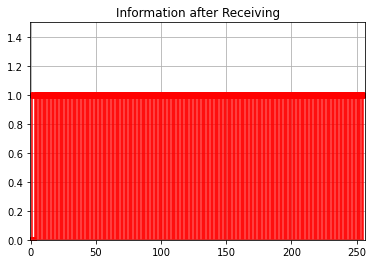

In [459]:
# Plot binary
plt.figure()
plt.stem(range(len(Rx_data)), Rx_data, linefmt='r-', markerfmt='ro')
plt.title('Information after Receiving')
plt.axis([-.5, len(Rx_data) + .5, 0, 1.5])
plt.grid(True)

print("Received binary: ", Rx_data)

# Convert binary to integer
received_integer = binary_array_to_int(Rx_data.astype(int))
#print("Received integer: ", received_integer)

# Convert integer to bytes
rec_bytes_representation = received_integer.to_bytes((received_integer.bit_length() + 7) // 8, byteorder='big')

# Decode bytes back to string
decoded_string = rec_bytes_representation.decode('ascii') # WHAT ENCODING SCHEME DID WE USE?


plt.show()


print("Received Word: ", decoded_string)

In [ ]:
window = np.array(np.blackman(number_samples)[:])
# print("window:", window)
# print("cdata:", cdata[0])

# downsample_window = np.array(np.blackman(number_samples/downsample_factor)[:])
# print("window:", window)
# print("cdata:", cdata[0])

wdata = []
wfigs = []
wdata.append(cdata[0]*window)
# print("wdata:", wdata[0])
# wfigs.append(plot_complex_time(
#         data=wdata[0], 
#         title=''.join(['Windowed Plot of ADC Channel ', str(2), ' Before Downconversion'])))

# wdata.append(downsampled_signal*downsample_window)
# wfigs.append(plot_complex_time(
#         data=wdata[1], 
#         title=''.join(['Windowed Plot of ADC Channel ', str(2), ' After Downconversion'])))

# ipw.VBox(wfigs)

In [ ]:
fdata = []
for i in range(0, len(wdata)):
    fdata.append(np.fft.fftshift(np.fft.fft(wdata[i])))

In [ ]:
def plot_complex_spectrum(data, N=number_samples, fs=sample_frequency, 
                          title='Complex Spectrum Plot', units='dBW', fc=0):
    plt_temp = (go.Scatter(x = np.arange(-fs/2, fs/2, fs/N) + fc,
                           y = data, name='Spectrum'))
    return go.FigureWidget(data = plt_temp,
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Frequency (Hz)',
                                         'autorange': True},
                                     'yaxis': {
                                         'title': units}})

magfigs = []
for i in range(0, len(fdata)):
    magfigs.append(plot_complex_spectrum(
            data=abs(fdata[i]),
            title=''.join(['Frequency Magnitude Plot of ADC Channel ', str(i)]),
            units='|Y(f)|',
            fc=round(abs(base.radio.receiver.channel[i].adc_block.MixerSettings['Freq']))*1e6))

ipw.VBox(magfigs)